In [1]:
import numpy as np
import xarray as xr
import pickle as pk
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression as lr 
from sklearn.metrics import r2_score as r2_score
from scipy.optimize import curve_fit as curve_fit
import statsmodels.api as sm
import matplotlib as mpl
mpl.rc('font',size=16,**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
def int_alpha(ands,ors):
    fit = lr().fit(ors,ands)
    return fit.intercept_, fit.coef_[0]
def pred(ands,ors):
    fit = lr().fit(ors,ands)
    predict = fit.predict(ors)
    return predict

In [3]:
#read in step response data
path = '/Volumes/eSSD0/Papers/JoC_gFBK/Data/'
case = ['ctl.2']

    
pi = pk.load(open(path+'SI/b.e12.pi-control.T31_g37.ctl.2_ctl_diag.pk','rb'))
p1 = pk.load(open(path+'Outputs/b.e12.1pyCO2.T31_g37.ctl.open.2_ctl_diag.pk','rb'))
ebp1  = pk.load(open(path+'Outputs/EB/b.e12.1pyCO2.T31_g37.ctl.open.2_EB_gam.pk','rb'))
ebp1['net'] = ebp1['salb']+ebp1['Planck']+ebp1['lapse']+ebp1['q_tropo']+ebp1['cld_lw']+ebp1['cld_sw']
dp1  = p1['tas']-np.mean(pi['tas'][-30:])


In [4]:
p1intercepts = {}
p1alphas = {}
p1prediction = {}

for terms in ebp1.keys():

    p1intercepts[terms], p1alphas[terms] = int_alpha(ebp1[terms],dp1.reshape(-1,1))
    p1prediction[terms] = pred(ebp1[terms],dp1.reshape(-1,1))

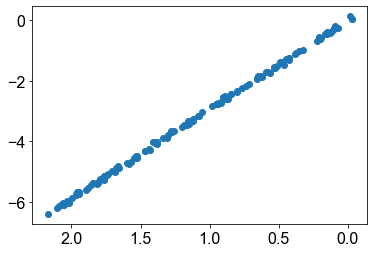

In [5]:
axt = plt.subplot() 
plt.scatter(dp1,ebp1['Planck'])
axt.invert_xaxis()

In [6]:
tas_addcons = sm.add_constant(dp1)
regres_ols = {}
fit = {}
conf = {}
error = {}
sig = {}
for keys in ebp1.keys():
    regres_ols[keys] = sm.OLS(ebp1[keys],tas_addcons)
    fit[keys] = regres_ols[keys].fit()
    conf[keys] = fit[keys].conf_int()[1,:]
    error[keys] = fit[keys].params[1]-conf[keys][0]
    sig[keys] = fit[keys].pvalues[1] < 0.05

In [7]:
for keys in error.keys():
    print(keys)
    print(f'{round(conf[keys][0],3)} , {round(p1alphas[keys],3)} , {round(conf[keys][1],3)}')

salb
0.312 , 0.322 , 0.332
ta_strato
0.337 , 0.348 , 0.359
lapse
-0.31 , -0.281 , -0.253
Planck
-2.958 , -2.947 , -2.935
q_strato
0.028 , 0.028 , 0.029
q_tropo
1.282 , 1.312 , 1.341
cld_lw
0.448 , 0.48 , 0.512
cld_sw
-0.507 , -0.441 , -0.376
IRF
1.592 , 1.625 , 1.657
cld_sw_lo
0.205 , 0.242 , 0.279
cld_sw_hi
-0.742 , -0.683 , -0.624
cld_lw_lo
-0.028 , -0.023 , -0.019
cld_lw_hi
0.471 , 0.503 , 0.536
net
-1.621 , -1.556 , -1.49


In [8]:
conffinal = {}
conffinal['$\lambda_{a}$'] = error['salb']
conffinal['$\lambda_{P}$'] = error['Planck']
conffinal['$\lambda_{lr}$'] = error['lapse']
conffinal['$\lambda_{wv}$'] = error['q_tropo']
conffinal['$\lambda_{c-lw}$'] = error['cld_lw']
conffinal['$\lambda_{c-sw}$'] = error['cld_sw']
conffinal['$\lambda_{net}$'] = error['net']

In [9]:
error_plot = np.stack(conffinal.values(),axis=0)

/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [10]:
p1final = {}
p1final['$\lambda_{a}$'] = p1alphas['salb']
p1final['$\lambda_{P}$'] = p1alphas['Planck']
p1final['$\lambda_{lr}$'] = p1alphas['lapse']
p1final['$\lambda_{wv}$'] = p1alphas['q_tropo']
p1final['$\lambda_{c-lw}$'] = p1alphas['cld_lw']
p1final['$\lambda_{c-sw}$'] = p1alphas['cld_sw']
p1final['$\lambda_{net}$'] = p1alphas['net']

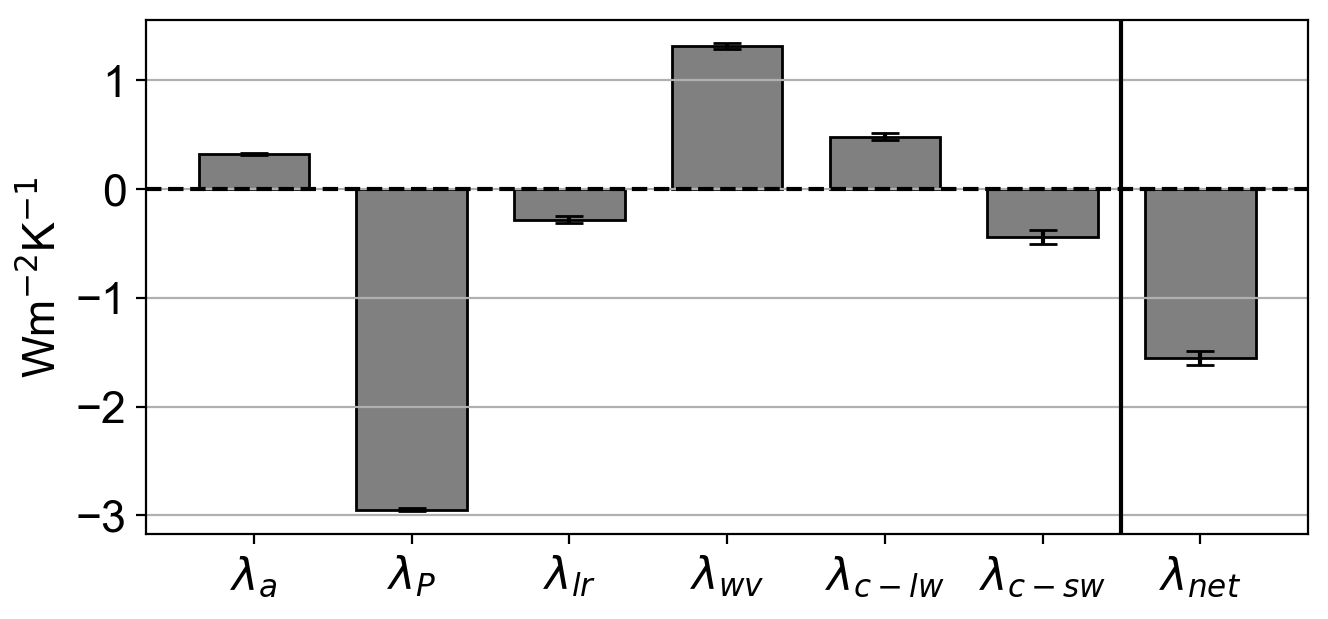

In [11]:
plt.figure(figsize=(7.5,7.5),dpi=200)

plt.subplot(211)
plt.bar(np.arange(7),list(p1final.values()), width=0.7,align='center',edgecolor='k', color='grey', yerr=error_plot, capsize=5)
plt.axhline(0,color='k',linestyle = '--')
plt.axvline(5.5,color='k')
plt.grid(axis='y')
plt.ylabel('Wm$^{-2}$K$^{-1}$')
plt.xticks(np.arange(7),labels = list(p1final.keys()));

plt.savefig('fbk_bar.png',bbox_inches='tight')